In [2]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

In [4]:
aug_speeds = {"keyboard": 117, "char_substitute": 109, "char_insert": 109, "char_swap": 114,
              "ocr": 114, "char_delete": 108,
              "word_insert": 0.0, "word_substitute": 0.0, "text_rotate": 32,
              "stopword_insert": 34, "word_join": 32, "word_cutout": 36,
              "w2v_insert": 0.0, "w2v_substitute": 0.0, 
              "fasttext": 137, "glove_twitter": 88, "glove_wiki": 82, "word2vec": 137,
              "synonym": 522, "split": 110, "sentence_shuffle": 67, "one_third_cut": 0.0, "half_cut":0.0}


- What Augs are useful
- What Text models perform best

In [5]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, 
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# ImageAugment([0.2, 0.5, 0.3])


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [6]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [7]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()
augmentation_weights = {"None": 1.0}



# Fasttext 1D CNN

## 512 DIMS

In [ ]:
epochs = 15
model_fn = model_builder(Fasttext1DCNNModel, 
                         dict(classifier_dims=256, num_classes=2, 
                              n_layers=2, final_layer_builder=fb_1d_loss_builder,
                              gaussian_noise=0.15, dropout=0.2, embedding_dims=256, internal_dims=512,
                             fasttext_file="crawl-300d-2M-subword.bin", featurizer="transformer",),
                         optimiser_class=optimizer, optimiser_params=optimizer_params)





multi_eval=False 
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs

# 0.738	0.734
# 0.730	0.715
# 0.730	0.715
# 0.734	0.731
# 0.746	0.712


# Lang Features Model

In [ ]:
epochs = 15
batch_size=256
# fasttext_crawl 1.9s
# spacy 1.8s
# full_view 1.4s 0.659	0.651
# gensim 7.5s # 0.718	0.737
# nltk 3s 0.609	0.585
# "spacy", "key_phrases" 4.2s 0.688	0.670
# "fasttext_crawl", "spacy", "key_phrases", "gensim" 20s 0.763	0.729 2h 49m
# "fasttext_crawl", "gensim" 11s 0.749	0.733 1h 47m
# gensim 8s 0.751	0.733 1h 20m

all_caps = ["fasttext_crawl", "spacy", "full_view", "key_phrases", "nltk", "gensim"] # "snlp", "ibm_max", "tmoji", "key_phrases", "full_view", "spacy", "nltk", "fasttext_crawl"
all_caps = ["full_view",]
all_caps = ["fasttext_crawl", "spacy", "key_phrases", "nltk"]
all_caps = ["fasttext_crawl", "gensim"]
model_fn = model_builder(LangFeaturesModel, 
                         dict(classifier_dims=256, num_classes=2, 
                              gaussian_noise=0.2, dropout=0.2, embedding_dims=256, internal_dims=512,
                              capabilities=all_caps, featurizer="transformer", n_layers=2, 
                              final_layer_builder=fb_1d_loss_builder),
                         optimiser_class=optimizer, optimiser_params=optimizer_params)



multi_eval=False
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19])
r1, p1 = results, prfs
results
prfs


# BERT Models

## Not FineTuned

### DistilRoberta

In [ ]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=4.75,
                              dropout=0.15,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilroberta-base',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)

# 0.0.760	0.745 (725	0.721) # 15m 41s


### Actibus/Bert_REview

In [ ]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "9": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "10": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "11": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=6.75,
                              dropout=0.175,
                              word_masking_proba=0.25,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model="activebus/BERT_Review"),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.759	0.752 (0.717	0.716)

# 0.0.760	0.745 (725	0.721) # 15m 41s


## MLM Finetune only

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.405933 LR = 0.00000007



Epoch =  2 Loss = 0.402387 LR = 0.00000014



Epoch =  3 Loss = 0.396804 LR = 0.00000021



Epoch =  4 Loss = 0.361454 LR = 0.00000028
Epoch =  4 Train = 0.628692 Val = 0.642245



Epoch =  5 Loss = 0.324780 LR = 0.00000035



Epoch =  6 Loss = 0.313004 LR = 0.00000042



Epoch =  7 Loss = 0.306607 LR = 0.00000049
Epoch =  7 Train = 0.631743 Val = 0.642168



Epoch =  8 Loss = 0.300342 LR = 0.00000056



Epoch =  9 Loss = 0.274422 LR = 0.00000062
Epoch =  9 Train = 0.655270 Val = 0.657628



Epoch =  10 Loss = 0.272907 LR = 0.00000069



Epoch =  11 Loss = 0.252483 LR = 0.00000076
Epoch =  11 Train = 0.693603 Val = 0.676615



Epoch =  12 Loss = 0.231375 LR = 0.00000083



Epoch =  13 Loss = 0.239452 LR = 0.00000090



Epoch =  14 Loss = 0.222644 LR = 0.00000097
Epoch =  14 Train = 0.722885 Val = 0.688503



Epoch =  15 Loss = 0.219830 LR = 0.00000100



Epoch =  16 Loss = 0.218904 LR = 0.00000099



Epoch =  17 Loss = 0.221277 LR = 0.00000099
Epoch =  17 Train = 0.740617 Val = 0.715956



Epoch =  18 Loss = 0.213070 LR = 0.00000097



Epoch =  19 Loss = 0.200531 LR = 0.00000095
Epoch =  19 Train = 0.748492 Val = 0.717745



Epoch =  20 Loss = 0.197305 LR = 0.00000093



Epoch =  21 Loss = 0.189886 LR = 0.00000091



Epoch =  22 Loss = 0.204401 LR = 0.00000088



Epoch =  23 Loss = 0.197746 LR = 0.00000085
Epoch =  23 Train = 0.747336 Val = 0.713233



Epoch =  24 Loss = 0.197438 LR = 0.00000081



Epoch =  25 Loss = 0.181806 LR = 0.00000077



Epoch =  26 Loss = 0.180425 LR = 0.00000073



Epoch =  27 Loss = 0.163356 LR = 0.00000069
Epoch =  27 Train = 0.753308 Val = 0.718445



Epoch =  28 Loss = 0.165564 LR = 0.00000065



Epoch =  29 Loss = 0.159268 LR = 0.00000060



Epoch =  30 Loss = 0.157728 LR = 0.00000056



Epoch =  31 Loss = 0.151395 LR = 0.00000051
Epoch =  31 Train = 0.756965 Val = 0.722876



Epoch =  32 Loss = nan LR = 0.00000046



Epoch =  33 Loss = 0.148282 LR = 0.00000042



Epoch =  34 Loss = 0.146016 LR = 0.00000037
Epoch =  34 Train = 0.761809 Val = 0.725368



Epoch =  35 Loss = 0.138612 LR = 0.00000033



Epoch =  36 Loss = 0.142558 LR = 0.00000028



Epoch =  37 Loss = 0.143255 LR = 0.00000024
Epoch =  37 Train = 0.761787 Val = 0.723427



Epoch =  38 Loss = 0.143209 LR = 0.00000020



Epoch =  39 Loss = 0.139941 LR = 0.00000017



Epoch =  40 Loss = 0.132503 LR = 0.00000013



Epoch =  41 Loss = 0.133854 LR = 0.00000010
Epoch =  41 Train = 0.764163 Val = 0.725537



Epoch =  42 Loss = 0.130974 LR = 0.00000008



Epoch =  43 Loss = 0.131479 LR = 0.00000005



Epoch =  44 Loss = 0.133742 LR = 0.00000003
Epoch =  44 Train = 0.764582 Val = 0.725912



Epoch =  45 Loss = 0.130892 LR = 0.00000002



Epoch =  46 Loss = 0.130453 LR = 0.00000001



Epoch =  47 Loss = 0.129868 LR = 0.00000000
Epoch =  47 Train = 0.764761 Val = 0.725738



Epoch =  48 Loss = 0.129405 LR = 0.00000000



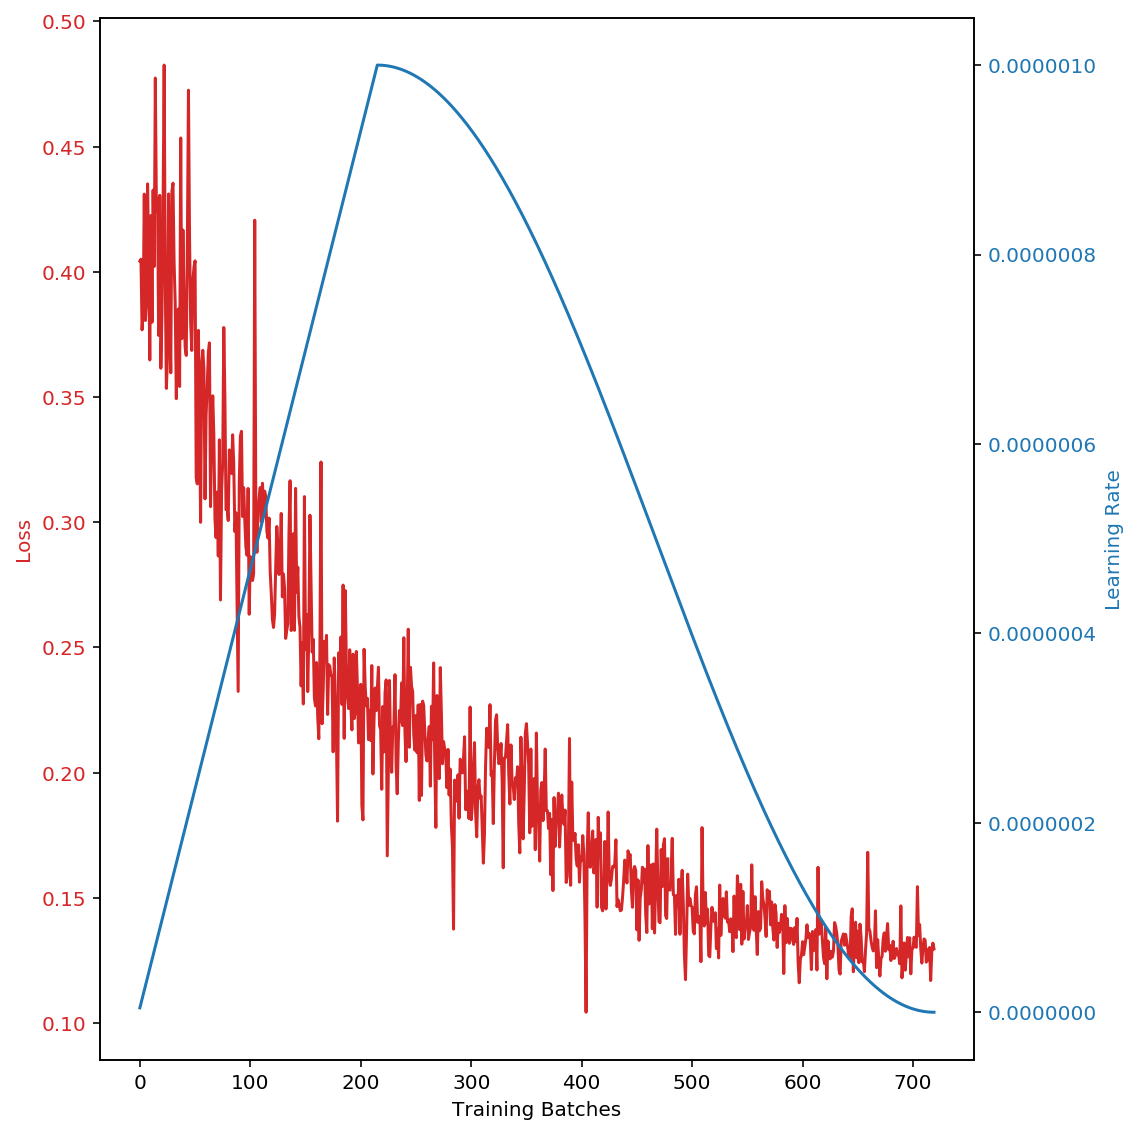

train   val
mean_or_std metric               
mean        map       0.660 0.609
            accuracy  0.729 0.706
            auc       0.765 0.726
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.738  0.889 0.806 4560.000     0.724  0.866 0.788 1140.000
pos     0.703  0.454 0.551 2640.000     0.649  0.429 0.516  660.000

In [14]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.25,
                              dropout=0.175,
                              internal_dims=512,
                              word_masking_proba=0.0,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.756	0.759 (0.726	0.711) # 17m 19s



## Aug Sim Finetune

Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.408154 LR = 0.00000007



Epoch =  2 Loss = 0.407774 LR = 0.00000014



Epoch =  3 Loss = 0.382011 LR = 0.00000021



Epoch =  4 Loss = 0.357112 LR = 0.00000028
Epoch =  4 Train = 0.625436 Val = 0.630027



Epoch =  5 Loss = 0.342132 LR = 0.00000035



Epoch =  6 Loss = 0.318525 LR = 0.00000042



Epoch =  7 Loss = 0.308450 LR = 0.00000049
Epoch =  7 Train = 0.631297 Val = 0.633941



Epoch =  8 Loss = 0.285061 LR = 0.00000056



Epoch =  9 Loss = 0.259616 LR = 0.00000062
Epoch =  9 Train = 0.624947 Val = 0.627906



Epoch =  10 Loss = 0.250506 LR = 0.00000069



Epoch =  11 Loss = 0.248159 LR = 0.00000076
Epoch =  11 Train = 0.619619 Val = 0.623172



Epoch =  12 Loss = 0.254007 LR = 0.00000083



Epoch =  13 Loss = 0.233482 LR = 0.00000090



Epoch =  14 Loss = 0.228208 LR = 0.00000097
Epoch =  14 Train = 0.621049 Val = 0.627487



Epoch =  15 Loss = 0.228750 LR = 0.00000100



Epoch =  16 Loss = 0.226644 LR = 0.00000099



Epoch =  17 Loss = 0.220371 LR = 0.00000099
Epoch =  17 Train = 0.626332 Val = 0.629932



Epoch =  18 Loss = 0.227033 LR = 0.00000097



Epoch =  19 Loss = 0.208214 LR = 0.00000095
Epoch =  19 Train = 0.633930 Val = 0.637123



Epoch =  20 Loss = 0.199321 LR = 0.00000093



Epoch =  21 Loss = 0.200016 LR = 0.00000091



Epoch =  22 Loss = 0.187343 LR = 0.00000088



Epoch =  23 Loss = 0.179397 LR = 0.00000085
Epoch =  23 Train = 0.676848 Val = 0.677996



Epoch =  24 Loss = 0.171201 LR = 0.00000081



Epoch =  25 Loss = 0.172666 LR = 0.00000077



Epoch =  26 Loss = 0.162475 LR = 0.00000073



Epoch =  27 Loss = 0.165398 LR = 0.00000069
Epoch =  27 Train = 0.733022 Val = 0.717264



Epoch =  28 Loss = 0.156354 LR = 0.00000065



Epoch =  29 Loss = 0.148895 LR = 0.00000060



Epoch =  30 Loss = 0.149071 LR = 0.00000056



Epoch =  31 Loss = 0.149534 LR = 0.00000051
Epoch =  31 Train = 0.743630 Val = 0.717479



Epoch =  32 Loss = 0.144693 LR = 0.00000046



Epoch =  33 Loss = 0.140966 LR = 0.00000042



Epoch =  34 Loss = 0.138271 LR = 0.00000037
Epoch =  34 Train = 0.749294 Val = 0.724702



Epoch =  35 Loss = 0.132403 LR = 0.00000033



Epoch =  36 Loss = 0.135553 LR = 0.00000028



Epoch =  37 Loss = 0.131696 LR = 0.00000024
Epoch =  37 Train = 0.751952 Val = 0.730815



Epoch =  38 Loss = 0.129086 LR = 0.00000020



Epoch =  39 Loss = 0.127850 LR = 0.00000017



Epoch =  40 Loss = 0.129272 LR = 0.00000013



Epoch =  41 Loss = 0.125253 LR = 0.00000010
Epoch =  41 Train = 0.753517 Val = 0.729870



Epoch =  42 Loss = 0.129517 LR = 0.00000008



Epoch =  43 Loss = 0.124479 LR = 0.00000005



Epoch =  44 Loss = 0.125260 LR = 0.00000003
Epoch =  44 Train = 0.754592 Val = 0.731021



Epoch =  45 Loss = 0.123073 LR = 0.00000002



Epoch =  46 Loss = 0.125962 LR = 0.00000001



Epoch =  47 Loss = 0.123436 LR = 0.00000000
Epoch =  47 Train = 0.755170 Val = 0.731063



Epoch =  48 Loss = 0.126497 LR = 0.00000000



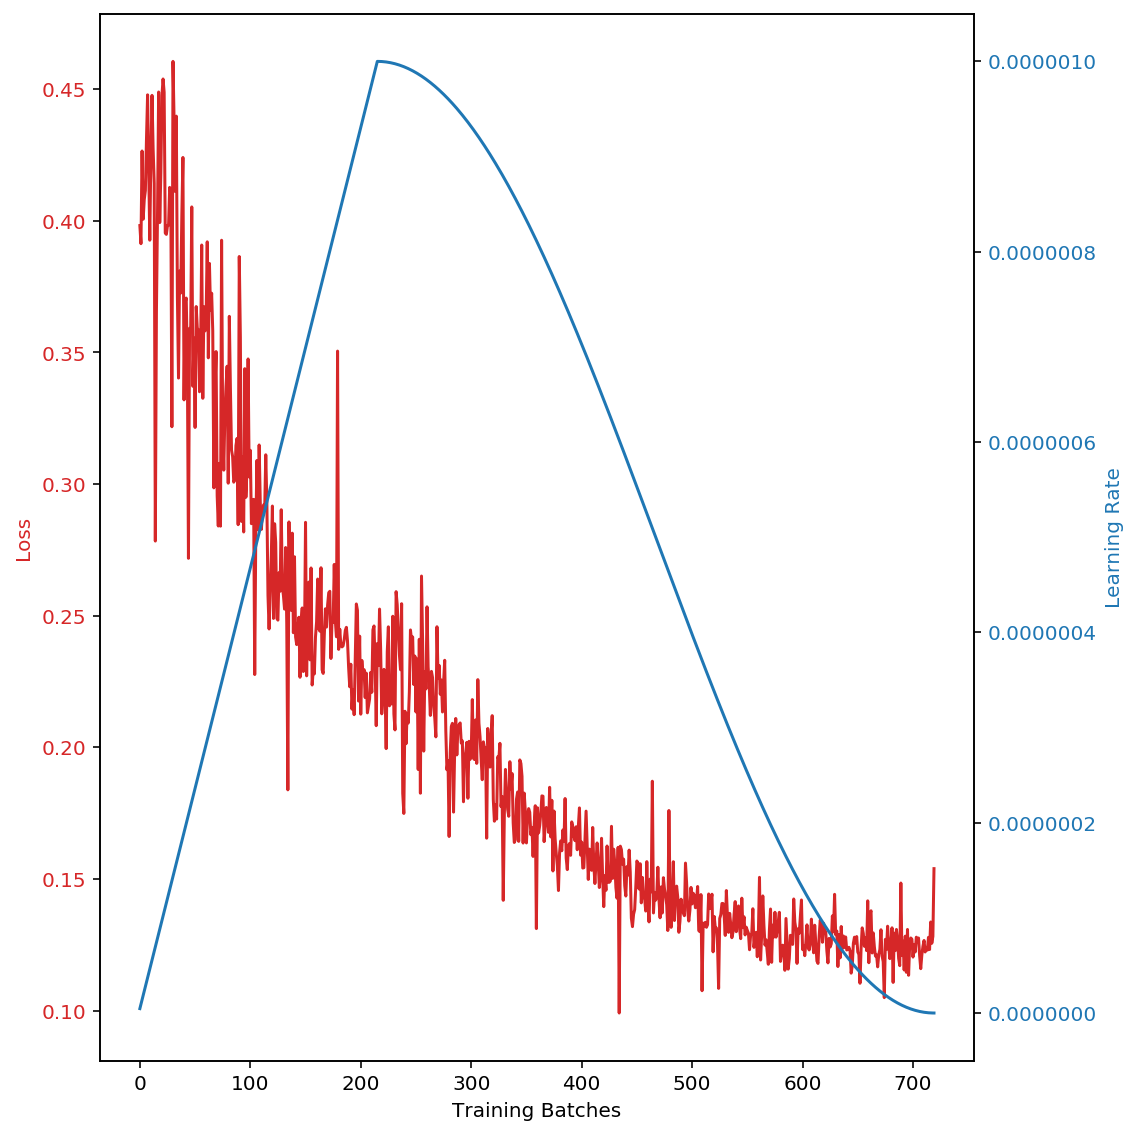

train   val
mean_or_std metric               
mean        map       0.654 0.620
            accuracy  0.724 0.713
            auc       0.755 0.731
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.736  0.880 0.802 4560.000     0.726  0.880 0.795 1140.000
pos     0.687  0.455 0.548 2640.000     0.672  0.426 0.521  660.000

In [11]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.25,
                              dropout=0.175,
                              word_masking_proba=0.175,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-augsim',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.754	0.738



Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.408878 LR = 0.00000007



Epoch =  2 Loss = 0.427514 LR = 0.00000014



Epoch =  3 Loss = 0.360970 LR = 0.00000021



Epoch =  4 Loss = 0.366278 LR = 0.00000028
Epoch =  4 Train = 0.629844 Val = 0.639231



Epoch =  5 Loss = 0.356487 LR = 0.00000035



Epoch =  6 Loss = 0.353455 LR = 0.00000042



Epoch =  7 Loss = 0.324090 LR = 0.00000049
Epoch =  7 Train = 0.626943 Val = 0.641511



Epoch =  8 Loss = 0.288580 LR = 0.00000056



Epoch =  9 Loss = 0.271962 LR = 0.00000062
Epoch =  9 Train = 0.624122 Val = 0.640879



Epoch =  10 Loss = 0.256748 LR = 0.00000069



Epoch =  11 Loss = 0.257634 LR = 0.00000076
Epoch =  11 Train = 0.622092 Val = 0.635004



Epoch =  12 Loss = 0.257186 LR = 0.00000083



Epoch =  13 Loss = 0.246600 LR = 0.00000090



Epoch =  14 Loss = 0.232891 LR = 0.00000097
Epoch =  14 Train = 0.628994 Val = 0.641484



Epoch =  15 Loss = 0.225693 LR = 0.00000100



Epoch =  16 Loss = 0.224021 LR = 0.00000099



Epoch =  17 Loss = 0.211169 LR = 0.00000099
Epoch =  17 Train = 0.613971 Val = 0.619171



Epoch =  18 Loss = 0.211343 LR = 0.00000097



Epoch =  19 Loss = 0.217499 LR = 0.00000095
Epoch =  19 Train = 0.626652 Val = 0.637507


Exception for:  keyboard | ' ' ' ' | ['word_cutout' 'char_delete' 'one_third_cut' 'char_swap' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  20 Loss = 0.183065 LR = 0.00000093



Epoch =  21 Loss = 0.190184 LR = 0.00000091



Epoch =  22 Loss = 0.192784 LR = 0.00000088



Epoch =  23 Loss = 0.181719 LR = 0.00000085
Epoch =  23 Train = 0.634178 Val = 0.646062



Epoch =  24 Loss = 0.185693 LR = 0.00000081



Epoch =  25 Loss = 0.169579 LR = 0.00000077



Epoch =  26 Loss = 0.176710 LR = 0.00000073



Epoch =  27 Loss = 0.173782 LR = 0.00000069
Epoch =  27 Train = 0.636524 Val = 0.648610



Epoch =  28 Loss = 0.160955 LR = 0.00000065



Epoch =  29 Loss = 0.157716 LR = 0.00000060



Epoch =  30 Loss = 0.157728 LR = 0.00000056



Epoch =  31 Loss = 0.150417 LR = 0.00000051
Epoch =  31 Train = 0.643812 Val = 0.652784



Epoch =  32 Loss = 0.150526 LR = 0.00000046



Epoch =  33 Loss = 0.144629 LR = 0.00000042



Epoch =  34 Loss = 0.143389 LR = 0.00000037
Epoch =  34 Train = 0.677279 Val = 0.676699



Epoch =  35 Loss = 0.135795 LR = 0.00000033



Epoch =  36 Loss = 0.136733 LR = 0.00000028



Epoch =  37 Loss = 0.133913 LR = 0.00000024
Epoch =  37 Train = 0.705386 Val = 0.703028



Epoch =  38 Loss = 0.131302 LR = 0.00000020



Epoch =  39 Loss = 0.129851 LR = 0.00000017



Epoch =  40 Loss = 0.131593 LR = 0.00000013



Epoch =  41 Loss = 0.130541 LR = 0.00000010
Epoch =  41 Train = 0.725506 Val = 0.715708



Epoch =  42 Loss = 0.127109 LR = 0.00000008



Epoch =  43 Loss = 0.124589 LR = 0.00000005



Epoch =  44 Loss = 0.125816 LR = 0.00000003
Epoch =  44 Train = 0.729074 Val = 0.718202



Epoch =  45 Loss = 0.122954 LR = 0.00000002



Epoch =  46 Loss = 0.123649 LR = 0.00000001



Epoch =  47 Loss = 0.122839 LR = 0.00000000
Epoch =  47 Train = 0.730187 Val = 0.718752



Epoch =  48 Loss = 0.122315 LR = 0.00000000



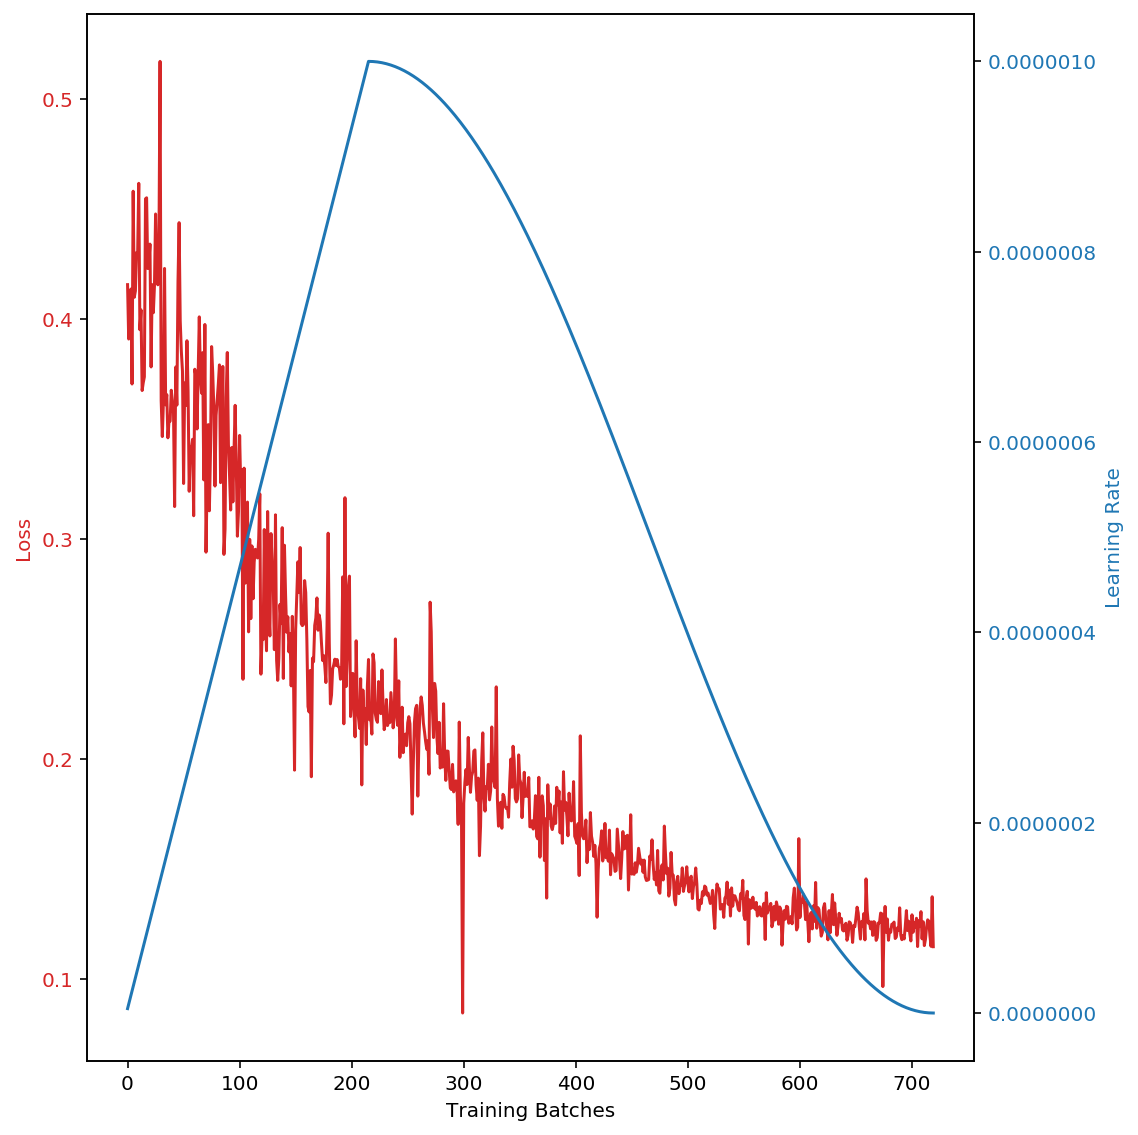

train   val
mean_or_std metric               
mean        map       0.620 0.600
            accuracy  0.705 0.701
            auc       0.730 0.719
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.740  0.822 0.779 4560.000     0.737  0.822 0.777 1140.000
pos     0.620  0.502 0.555 2640.000     0.616  0.492 0.547  660.000

In [15]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.5,
                              dropout=0.175,
                              word_masking_proba=0.175,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-augsim',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.754	0.738



Trainable Params = 18409984 
 AlbertClassifer(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)


Epoch =  1 Loss = 0.383328 LR = 0.00000007



Epoch =  2 Loss = 0.403650 LR = 0.00000014



Epoch =  3 Loss = 0.362909 LR = 0.00000021



Epoch =  4 Loss = 0.369468 LR = 0.00000028
Epoch =  4 Train = 0.626459 Val = 0.619172



Epoch =  5 Loss = 0.317287 LR = 0.00000035



Epoch =  6 Loss = 0.300647 LR = 0.00000042



Epoch =  7 Loss = 0.278284 LR = 0.00000049
Epoch =  7 Train = 0.619624 Val = 0.618898



Epoch =  8 Loss = 0.276798 LR = 0.00000056



Epoch =  9 Loss = 0.255808 LR = 0.00000062
Epoch =  9 Train = 0.623028 Val = 0.619121



Epoch =  10 Loss = 0.243139 LR = 0.00000069



Epoch =  11 Loss = 0.245860 LR = 0.00000076
Epoch =  11 Train = 0.612772 Val = 0.604329



Epoch =  12 Loss = 0.230906 LR = 0.00000083



Epoch =  13 Loss = 0.236096 LR = 0.00000090



Epoch =  14 Loss = 0.224642 LR = 0.00000097
Epoch =  14 Train = 0.626143 Val = 0.617079



Epoch =  15 Loss = 0.211215 LR = 0.00000100



Epoch =  16 Loss = 0.202998 LR = 0.00000099



Epoch =  17 Loss = 0.198028 LR = 0.00000099
Epoch =  17 Train = 0.631282 Val = 0.625057



Epoch =  18 Loss = 0.198978 LR = 0.00000097



Epoch =  19 Loss = 0.190162 LR = 0.00000095
Epoch =  19 Train = 0.627111 Val = 0.622440



Epoch =  20 Loss = 0.201046 LR = 0.00000093



Epoch =  21 Loss = 0.182912 LR = 0.00000091



Epoch =  22 Loss = 0.180823 LR = 0.00000088



Epoch =  23 Loss = 0.178265 LR = 0.00000085
Epoch =  23 Train = 0.644682 Val = 0.638115



Epoch =  24 Loss = 0.171057 LR = 0.00000081



Epoch =  25 Loss = 0.167995 LR = 0.00000077



Epoch =  26 Loss = 0.159687 LR = 0.00000073



Epoch =  27 Loss = 0.156779 LR = 0.00000069
Epoch =  27 Train = 0.661952 Val = 0.652318



Epoch =  28 Loss = 0.153268 LR = 0.00000065



Epoch =  29 Loss = 0.150782 LR = 0.00000060



Epoch =  30 Loss = 0.147517 LR = 0.00000056



Epoch =  31 Loss = 0.145383 LR = 0.00000051
Epoch =  31 Train = 0.714201 Val = 0.706907


Exception for:  keyboard | '' '' | ['word_cutout' 'half_cut' 'sentence_shuffle' 'text_rotate' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  32 Loss = 0.145649 LR = 0.00000046



Epoch =  33 Loss = 0.139105 LR = 0.00000042



Epoch =  34 Loss = 0.138615 LR = 0.00000037
Epoch =  34 Train = 0.722254 Val = 0.718054



Epoch =  35 Loss = 0.133207 LR = 0.00000033



Epoch =  36 Loss = 0.131492 LR = 0.00000028



Epoch =  37 Loss = 0.133239 LR = 0.00000024
Epoch =  37 Train = 0.731486 Val = 0.724367



Epoch =  38 Loss = 0.128482 LR = 0.00000020



Epoch =  39 Loss = 0.128637 LR = 0.00000017



Epoch =  40 Loss = 0.125897 LR = 0.00000013



Epoch =  41 Loss = 0.125000 LR = 0.00000010
Epoch =  41 Train = 0.739036 Val = 0.727126



Epoch =  42 Loss = 0.124794 LR = 0.00000008



Epoch =  43 Loss = 0.121976 LR = 0.00000005



Epoch =  44 Loss = 0.122874 LR = 0.00000003
Epoch =  44 Train = 0.740443 Val = 0.729244



Epoch =  45 Loss = 0.119783 LR = 0.00000002



Epoch =  46 Loss = 0.122029 LR = 0.00000001



Epoch =  47 Loss = 0.121798 LR = 0.00000000
Epoch =  47 Train = 0.740853 Val = 0.729676



Epoch =  48 Loss = 0.120025 LR = 0.00000000



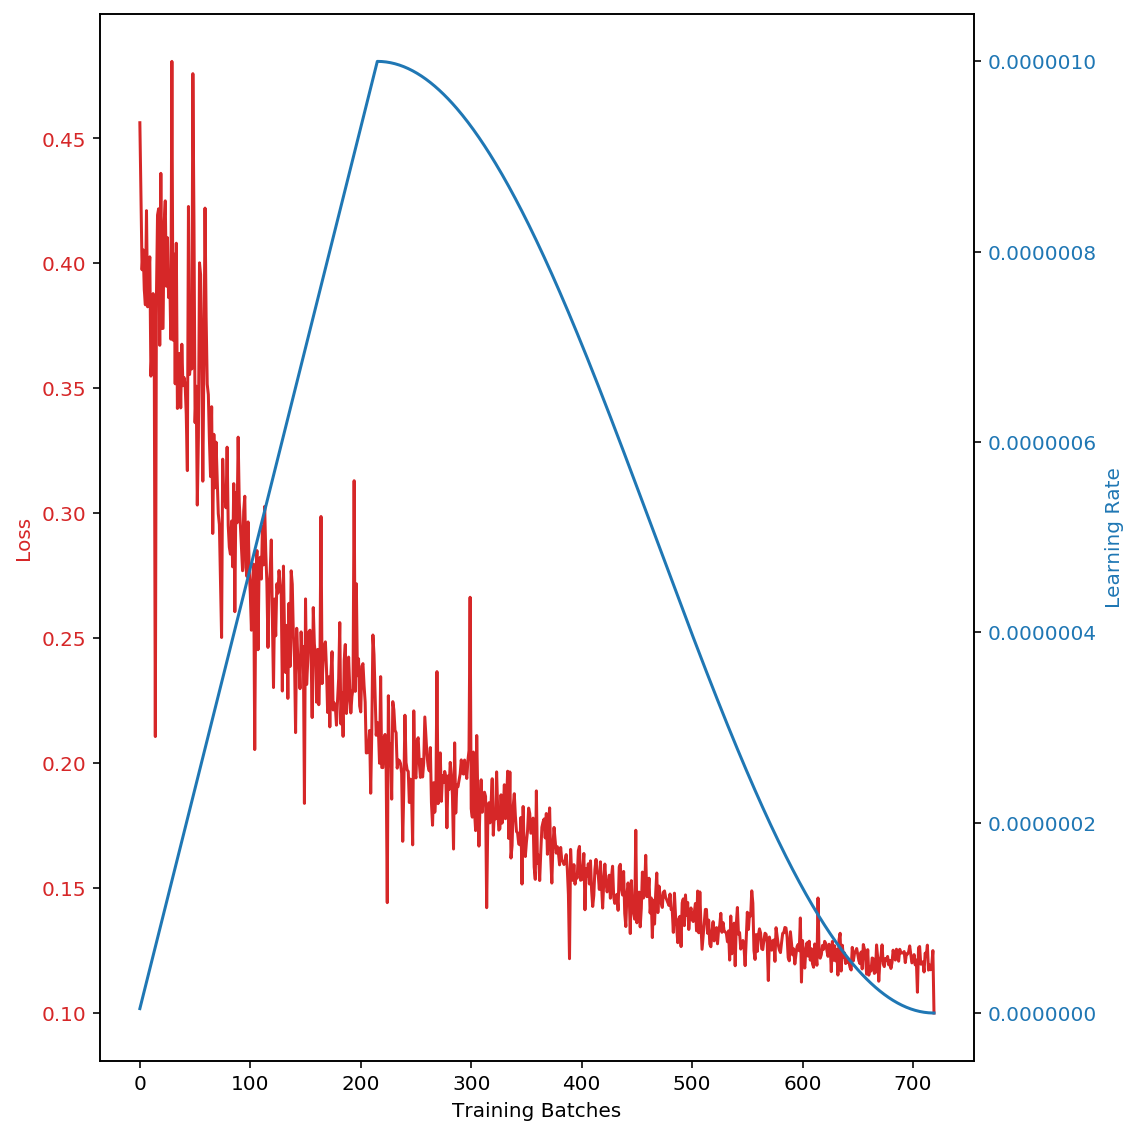

train   val
mean_or_std metric               
mean        map       0.627 0.616
            accuracy  0.711 0.711
            auc       0.741 0.730
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.725  0.876 0.793 4560.000     0.724  0.879 0.794 1140.000
pos     0.665  0.426 0.520 2640.000     0.668  0.421 0.517  660.000

In [18]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.25,
                              dropout=0.15,
                              word_masking_proba=0.175,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-augsim',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=True,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.754	0.738



## NSP Style Finetuned

In [ ]:
epochs = 24
batch_size = 256
lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "4": {
                    "lr": optimizer_params["lr"] / 1e2,
                    "finetune": False
                },
                "5": {
                    "lr": optimizer_params["lr"] / 1e1,
                    "finetune": True
                }
            }
        },
    }
}
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.5,
                              dropout=0.175,
                              word_masking_proba=0.25,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs

# 0.756	0.759 (0.726	0.711) # 17m 19s



In [ ]:

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.5,
                              dropout=0.175,
                              word_masking_proba=0.225,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched,
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs



Autocast =  True Epochs =  48 Divisor = 2 Examples = 3600 Batch Size =  256
Training Samples =  7200 Weighted Sampling =  True Num Batches =  15 Accumulation steps =  1



Epoch =  1 Loss = 0.409377 LR = 0.00000007



Epoch =  2 Loss = 0.426578 LR = 0.00000014



Epoch =  3 Loss = 0.377829 LR = 0.00000021



Epoch =  4 Loss = 0.383353 LR = 0.00000028
Epoch =  4 Train = 0.638558 Val = 0.627964



Epoch =  5 Loss = 0.329482 LR = 0.00000035



Epoch =  6 Loss = 0.322314 LR = 0.00000042



Epoch =  7 Loss = 0.295278 LR = 0.00000049
Epoch =  7 Train = 0.643049 Val = 0.635524



Epoch =  8 Loss = 0.299749 LR = 0.00000056



Epoch =  9 Loss = 0.267726 LR = 0.00000062
Epoch =  9 Train = 0.657419 Val = 0.652538



Epoch =  10 Loss = 0.266381 LR = 0.00000069



Epoch =  11 Loss = 0.258394 LR = 0.00000076
Epoch =  11 Train = 0.670397 Val = 0.661852



Epoch =  12 Loss = 0.244328 LR = 0.00000083



Epoch =  13 Loss = 0.230654 LR = 0.00000090



Epoch =  14 Loss = 0.219520 LR = 0.00000097
Epoch =  14 Train = 0.727921 Val = 0.706344



Epoch =  15 Loss = 0.213462 LR = 0.00000100


In [ ]:
# Either Regularization was too much or less
# Language pretraining was overdone so need to reduce LR there.


# Predict

In [11]:
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=5.5,
                              dropout=0.175,
                              word_masking_proba=0.2,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='./model-nsp',
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


Autocast =  True Epochs =  48 Divisor = 2 Examples = 4500 Batch Size =  256
Training Samples =  9000 Weighted Sampling =  True Num Batches =  18 Accumulation steps =  1



Epoch =  1 Loss = 0.408960 LR = 0.00000007



Epoch =  2 Loss = 0.404237 LR = 0.00000014



Epoch =  3 Loss = 0.374898 LR = 0.00000021



Epoch =  4 Loss = 0.355318 LR = 0.00000028



Epoch =  5 Loss = 0.308198 LR = 0.00000035



Epoch =  6 Loss = 0.280167 LR = 0.00000042



Epoch =  7 Loss = 0.263986 LR = 0.00000049



Epoch =  8 Loss = 0.238322 LR = 0.00000056



Epoch =  9 Loss = 0.221278 LR = 0.00000063



Epoch =  10 Loss = 0.218260 LR = 0.00000069



Epoch =  11 Loss = 0.200031 LR = 0.00000076



Epoch =  12 Loss = 0.195091 LR = 0.00000083



Epoch =  13 Loss = 0.193153 LR = 0.00000090



Epoch =  14 Loss = 0.186939 LR = 0.00000097



Epoch =  15 Loss = 0.181861 LR = 0.00000100



Epoch =  16 Loss = 0.173687 LR = 0.00000099



Epoch =  17 Loss = 0.173755 LR = 0.00000099



Epoch =  18 Loss = 0.161596 LR = 0.00000097



Epoch =  19 Loss = 0.163744 LR = 0.00000095



Epoch =  20 Loss = 0.154267 LR = 0.00000093



Epoch =  21 Loss = 0.147351 LR = 0.00000091



Epoch =  22 Loss = 0.145094 LR = 0.00000088



Epoch =  23 Loss = 0.142109 LR = 0.00000085



Epoch =  24 Loss = 0.138879 LR = 0.00000081



Epoch =  25 Loss = 0.136771 LR = 0.00000077



Epoch =  26 Loss = 0.131750 LR = 0.00000073



Epoch =  27 Loss = 0.125450 LR = 0.00000069



Epoch =  28 Loss = 0.130587 LR = 0.00000065



Epoch =  29 Loss = 0.127244 LR = 0.00000060



Epoch =  30 Loss = 0.121063 LR = 0.00000056



Epoch =  31 Loss = 0.120357 LR = 0.00000051



Epoch =  32 Loss = 0.118329 LR = 0.00000046



Epoch =  33 Loss = 0.118189 LR = 0.00000042



Epoch =  34 Loss = 0.115654 LR = 0.00000037



Epoch =  35 Loss = 0.113000 LR = 0.00000033



Epoch =  36 Loss = 0.111577 LR = 0.00000028



Epoch =  37 Loss = 0.110257 LR = 0.00000024



Epoch =  38 Loss = 0.110066 LR = 0.00000020


Exception for:  keyboard | '' '' | ['text_rotate' 'word_cutout' 'half_cut' 'one_third_cut' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  39 Loss = 0.109481 LR = 0.00000017



Epoch =  40 Loss = 0.109004 LR = 0.00000013



Epoch =  41 Loss = 0.108092 LR = 0.00000010



Epoch =  42 Loss = 0.107416 LR = 0.00000008



Epoch =  43 Loss = 0.106515 LR = 0.00000005



Epoch =  44 Loss = 0.105550 LR = 0.00000003



Epoch =  45 Loss = 0.106701 LR = 0.00000002



Epoch =  46 Loss = 0.106016 LR = 0.00000001



Epoch =  47 Loss = 0.106394 LR = 0.00000000



Epoch =  48 Loss = 0.105645 LR = 0.00000000



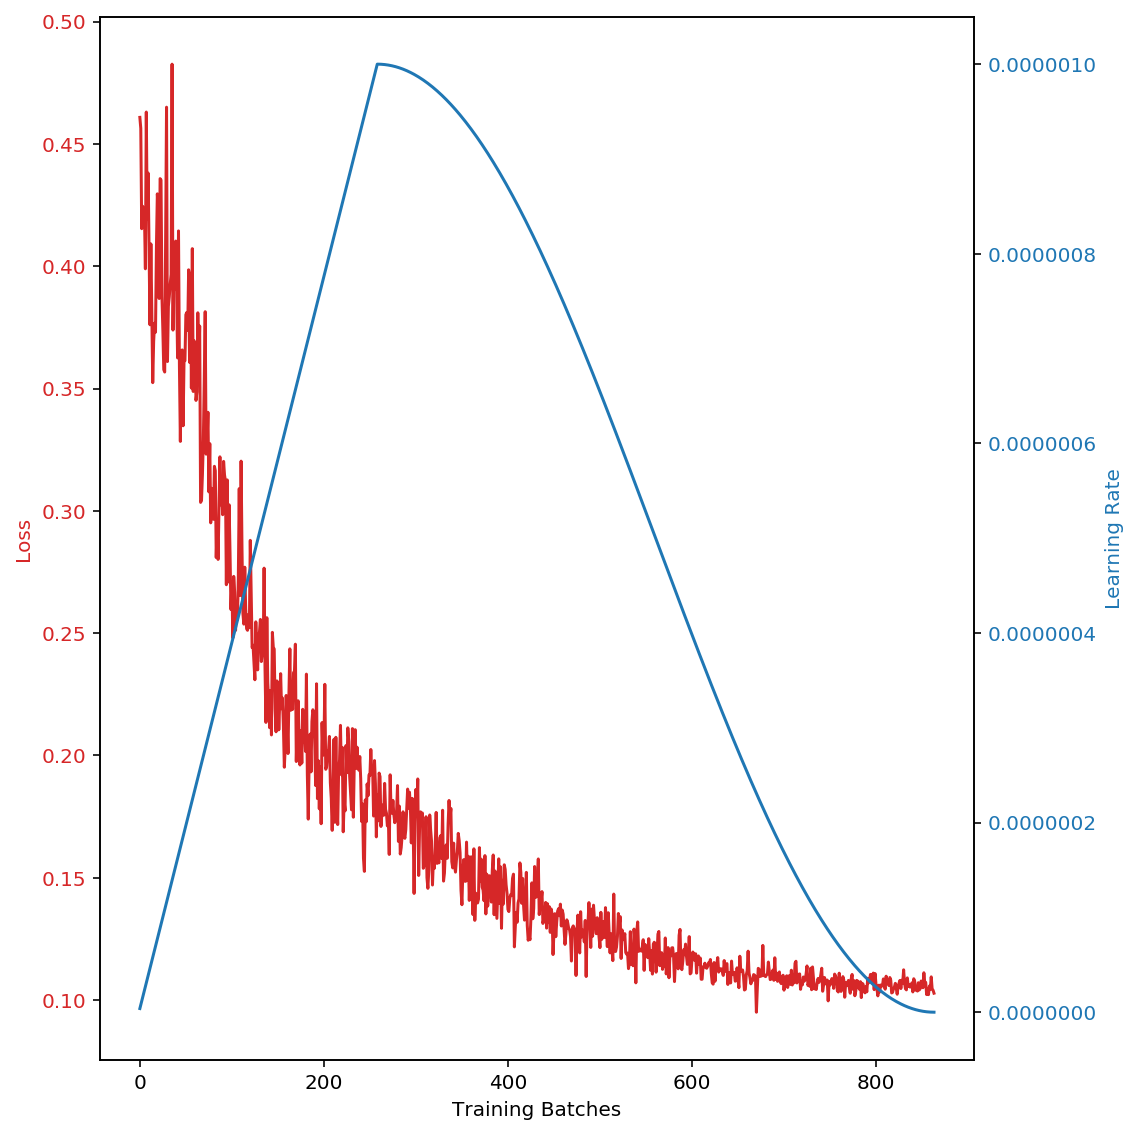

,id,proba,label
956,16042,0.528,1
433,71063,0.495,0
615,86193,0.469,0


In [12]:
epochs = 24
batch_size = 256

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, augmentation_weights, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement")
submission.to_csv("submission.csv",index=False)
submission.sample(3)


In [ ]:
submission.sample(10)